In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [5]:
data_path = "/stelmo/david/FXS/coh4/lesionEvaluation/FXScoh4/Cropped/"

In [6]:
import time
from itertools import combinations_with_replacement

import numpy as np
from skimage import io
from skimage.metrics import structural_similarity as ssim

anKey = np.array(
    [
        100,
        101,
        102,
        103,
        104,
        105,
        106,
        107,
        108,
        109,
        110,
        111,
        112,
        113,
        114,
        115,
        200,
        201,
        202,
        203,
        204,
        205,
        206,
        207,
        208,
    ]
)

control = np.array(
    [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]
)

output_size = {
    ("L", "Dorsal"): 363,
    ("L", "Intermediate"): 498,
    ("R", "Dorsal"): 349,
    ("R", "Intermediate"): 500,
}

In [4]:
LorR, hippoPart, sig = "L", "Dorsal", 50

In [8]:
from glob import glob

len(glob(f"{data_path}/{hippoPart}/{LorR}/101/*.tif"))

450

In [15]:
n_slices = output_size[(LorR, hippoPart)]
output = np.zeros((anKey.size, anKey.size, n_slices))
output.shape

(25, 25, 363)

In [18]:
i = 0

if i < 10:
    which = f"000{i}"
elif i < 100:
    which = f"00{i}"
elif i < 1000:
    which = f"0{i}"
else:
    which = str(i)

which

'0000'

In [20]:
sim = np.full((anKey.size, anKey.size), np.nan)
sim.shape

(25, 25)

In [24]:
from itertools import combinations

for i, j in combinations(range(anKey.size), 2):
    pass

In [25]:
str(anKey[i])

'207'

In [26]:
str(anKey[j])

'208'

In [70]:
from glob import glob
from os.path import basename

temp_path = glob(f"{data_path}/{hippoPart}/{LorR}/*")[0]
file_name = [basename(f) for f in glob(f"{temp_path}/*.tif")]

In [100]:
from dask_image.imread import imread

slice_id = 300
images = imread(f"{data_path}/{hippoPart}/{LorR}/**/*{LorR}{slice_id:04d}.tif")
images

dask.array<concatenate, shape=(25, 386, 687), dtype=uint8, chunksize=(1, 386, 687), chunktype=numpy.ndarray>

In [114]:
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
import dask.array as da
from glob import glob

slice_id = 300
filenames = glob(f"{data_path}/{hippoPart}/{LorR}/**/*{LorR}{slice_id:04d}.tif")
filenames = sorted(filenames, key=alphanumeric_key)
sample = imread(filenames[0])

lazy_imread = delayed(imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(delayed_reader, shape=sample.shape, dtype=sample.dtype)
    for delayed_reader in lazy_arrays
]
# Stack into one large dask.array
stack = da.stack(dask_arrays, axis=0)
stack

dask.array<stack, shape=(25, 386, 687), dtype=uint8, chunksize=(1, 386, 687), chunktype=numpy.ndarray>

In [71]:
n_animals = images.shape[0]
n_animals

25

In [92]:
from skimage.metrics import structural_similarity as ssim
import dask

result = [
    dask.delayed(ssim)(images[i], images[j], gaussian_weights=True, sigma=sig)
    for i, j in combinations(range(n_animals), 2)
]
result = np.asarray(dask.compute(*result, scheduler="processes"))

In [124]:
from lesion_similarity_analysis.core import (
    get_slice_filenames,
    load_images,
    compute_structural_similarity,
    get_animal_names,
)

filenames = get_slice_filenames(data_path, hippoPart, LorR, slice_id)
animal_names = get_animal_names(filenames, LorR)
images = load_images(filenames)
similarity = compute_structural_similarity(images, sig)

In [198]:
os.path.join("", "blah")

'blah'

In [134]:
output[list(combinations(range(n_animals), 2))].shape

IndexError: too many indices for array

In [149]:
output[np.triu_indices(n_animals, k=1)][:, slice_id] = similarity

In [156]:
blah = np.triu(similarity, k=1) + np.tril(similarity, k=1)

In [165]:
np.tril(similarity, k=1).shape

(300, 300)

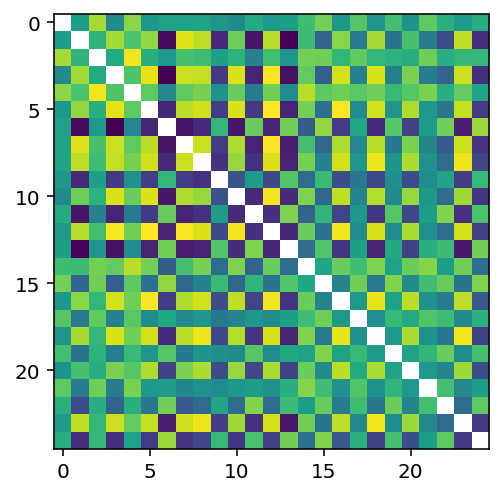

In [192]:
plt.imshow(output)

In [12]:
np.load?

Signature:
np.load(
    file,
    mmap_mode=None,
    allow_pickle=False,
    fix_imports=True,
    encoding='ASCII',
)
Docstring:
Load arrays or pickled objects from ``.npy``, ``.npz`` or pickled files.

.. warning:: Loading files that contain object arrays uses the ``pickle``
             module, which is not secure against erroneous or maliciously
             constructed data. Consider passing ``allow_pickle=False`` to
             load data that is known not to contain object arrays for the
             safer handling of untrusted sources.

Parameters
----------
file : file-like object, string, or pathlib.Path
    The file to read. File-like objects must support the
    ``seek()`` and ``read()`` methods. Pickled files require that the
    file-like object support the ``readline()`` method as well.
mmap_mode : {None, 'r+', 'r', 'w+', 'c'}, optional
    If not None, then memory-map the file, using the given mode (see
    `numpy.memmap` for a detailed description of the modes).  A
  

In [18]:
np.savetxt("test.txt", np.ones((10, 10, 10)))

ValueError: Expected 1D or 2D array, got 3D array instead

In [26]:
from lesion_similarity_analysis.core import get_slice_filenames, get_animal_names, compute_structural_similarity, complete_array, SLICE_SIZE, load_images

hippoPart, LorR = "Dorsal", "L"
sigma = 50
data_path = "/stelmo/david/FXS/coh4/lesionEvaluation/FXScoh4/Cropped/"

n_slices = SLICE_SIZE[LorR, hippoPart]
output = []

for slice_ind in tqdm(range(n_slices), desc="slices"):
    filenames = get_slice_filenames(data_path, hippoPart, LorR, slice_ind)
    animal_names = get_animal_names(filenames, LorR)
    n_animals = len(animal_names)
    images = load_images(filenames)
    similarity = compute_structural_similarity(images, sigma)
    similarity = complete_array(similarity, n_animals)
    output.append(similarity)

output = np.stack(output, axis=-1)

In [43]:
import xarray as xr

blah = xr.DataArray(output, dims=["animal1", "animal2", "slice"], coords={"animal1": animal_names, "animal2": animal_names, "slice": range(output.shape[-1])}, name="similarity").to_dataframe()
blah.to_csv("test")